In [201]:
!cd /data/store01/data_dirs/students/ucfafyi/Sentinel
import sys
sys.path.insert(0,'/data/store01/data_dirs/students/ucfafyi/Sentinel/python')
from fastRWpkl import *
from downloader_and_file_finder import *
from cloud import *
import pylab as plt
from scipy import signal
import scipy
from get_r import *
from matplotlib import gridspec
from scipy.stats import gaussian_kde
from nicer_plot import *
from matplotlib import cm, colors
import pandas as pd
import csv
from scipy import interpolate
%matplotlib inline

In [7]:
lat, lon, year = 37.181944, 114.36, 2016
sfiles, mfiles = get_closet(lat, lon,year,0)
keys = 'B02', 'B03','B04','B08','B8A','B11','B12'
bands = [2,3,4,8,13,11,12]

In [77]:
def gaussian(xwin, ywin, xstd, ystd, angle, norm = True):
    win = max(xwin, ywin)
    winx = win*2**0.5
    winy = win*2**0.5
    
    xstd = xstd*2**0.5
    ystd = ystd*2**0.5
        
    xgaus = signal.gaussian(winx, xstd)
    ygaus = signal.gaussian(winy, ystd)
    gaus  = np.outer(xgaus, ygaus)
    r_gaus = scipy.ndimage.interpolation.rotate(gaus, angle, reshape=True)
    center = np.array(r_gaus.shape)/2
    cgaus = r_gaus[center[0]-xwin/2: center[0]+xwin/2, center[1]-ywin/2:center[1]+ywin/2]
    if norm:
        return cgaus/cgaus.sum()
    else:
        return cgaus


def ScaleExtent(data, shape): # used for unifine different array,

    re = int(shape[0]/(data.shape[0]))

    a = np.repeat(np.repeat(data, re, axis = 1), re, axis =0)
    
    if (re*(data.shape[0])-shape[0]) != 0:
        extended = np.zeros(shape)
        extended[:re*(data.shape[0]),:re*(data.shape[0])] = a
        extended[re*(data.shape[0]):,re*(data.shape[0]):] = a[re*(data.shape[0])-shape[0]:, re*(data.shape[0])-shape[0]]
        return extended
    else:
        return a

In [87]:
#copy9
psfs = [[  24.03670488,  329.28109422,    8.21156216,  -21.92877746, 49.92825343,  103.24736351],
[  25.84989531,  319.13408271,    9.02137912,  -17.30119499, 54.28744309,  117.72072308],
[  20.34380686,  310.05258802,    7.68929054,  -20.20594463, 51.24613469,  125.79665481],
[  25.65831059,  331.77434   ,    8.26914652,  -18.98274506, 58.96302278,   93.93448873],
[  27.08271778,  331.96593023,    8.41321639,  -18.8125706 , 57.90903304,   92.61856343],
[  36.12786679,  240.59093701,    7.04018294,  -23.48520651, 58.81159708,  103.02285762],
[  28.58401928,  265.45895558,    7.2976923 ,  -19.74625101, 64.55664791,  115.26868696]]

In [88]:
psfs = np.array(psfs)
psfs

array([[  24.03670488,  329.28109422,    8.21156216,  -21.92877746,
          49.92825343,  103.24736351],
       [  25.84989531,  319.13408271,    9.02137912,  -17.30119499,
          54.28744309,  117.72072308],
       [  20.34380686,  310.05258802,    7.68929054,  -20.20594463,
          51.24613469,  125.79665481],
       [  25.65831059,  331.77434   ,    8.26914652,  -18.98274506,
          58.96302278,   93.93448873],
       [  27.08271778,  331.96593023,    8.41321639,  -18.8125706 ,
          57.90903304,   92.61856343],
       [  36.12786679,  240.59093701,    7.04018294,  -23.48520651,
          58.81159708,  103.02285762],
       [  28.58401928,  265.45895558,    7.2976923 ,  -19.74625101,
          64.55664791,  115.26868696]])

In [83]:
lat, lon, year = 37.181944, 114.36, 2016
sfiles, mfiles = get_closet(lat, lon,year,0)
keys = 'B02', 'B03','B04','B08','B8A','B11','B12'
bands = [2,3,4,8,13,11,12]
i=11
path = sfiles[i]

In [85]:
#sentm = get_cloud_mask(sfiles[i])
#minds, sinds = get_coords(lat,lon) 
#modis_filenames = gdal.Open(mfiles[i][0]).GetSubDatasets()
#modisQA = gdal.Open(mfiles[i][1]).GetSubDatasets()
#brdfs = get_rs(modisQA, modis_filenames, sfiles[i])

In [104]:
def cost(p, sent, sinds, mod, minds):    
    xstd,ystd,angle, xs, ys, windsize = p
    xwin,ywin = windsize, windsize
    
    to_regression =[]          
    cx = sinds[0]
    cy = sinds[1]
    mx = minds[0]
    my = minds[1]
    
    gaus = gaussian(xwin,ywin,xstd,ystd,angle,False)                              
    ker = gaus/(gaus.sum())

    s = signal.fftconvolve(sent, ker, mode='same')
    
    vld_x = ((cx+xs)>xwin/2)&((cx+xs)<10000-xwin/2)
    vld_y = ((cy+ys)>ywin/2)&((cy+ys)<10000-ywin/2)
    vld = vld_x&vld_y
    
    
    indx,indy = np.round((cx+xs)[vld]).astype(int), np.round((cy+ys)[vld]).astype(int)
    vals = s[indx,indy]
    brdf = mod[mx[vld], my[vld]]
    x,y = vals, brdf
    dif = abs(x-y)
    outliers = dif>0.15
    nanm = (np.isnan(x))|(np.isnan(y))|outliers
    return x[~nanm],y[~nanm]

def ScaleExtent(data, shape): # used for unifine different array,

    re = int(shape[0]/(data.shape[0]))

    a = np.repeat(np.repeat(data, re, axis = 1), re, axis =0)
    
    if (re*(data.shape[0])-shape[0]) != 0:
        extended = np.zeros(shape)
        extended[:re*(data.shape[0]),:re*(data.shape[0])] = a
        extended[re*(data.shape[0]):,re*(data.shape[0]):] = a[re*(data.shape[0])-shape[0]:, re*(data.shape[0])-shape[0]]
        return extended
    else:
        return a

for ind in range(7):
    if ind>=4:
        Sent = gdal_read(bands[ind], path)[keys[ind]]
        sent = ScaleExtent(Sent, (10980,10980)) 
        sent[sentm]=100000000000
        sent[np.isnan(sent)] = 100000000000
        if ind <4:
            data = cost(psfs[ind],sent,sinds, brdfs[ind]*0.001, minds)
            to_regs.append(data)
        else:
            data = cost(psfs[ind], sent,sinds, brdfs[ind-1]*0.001, minds)
            to_regs.append(data)

/data/store01/data_dirs/students/ucfafyi/.conda/envs/gdal_env/lib/python2.7/site-packages/ipykernel/__main__.py:14: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


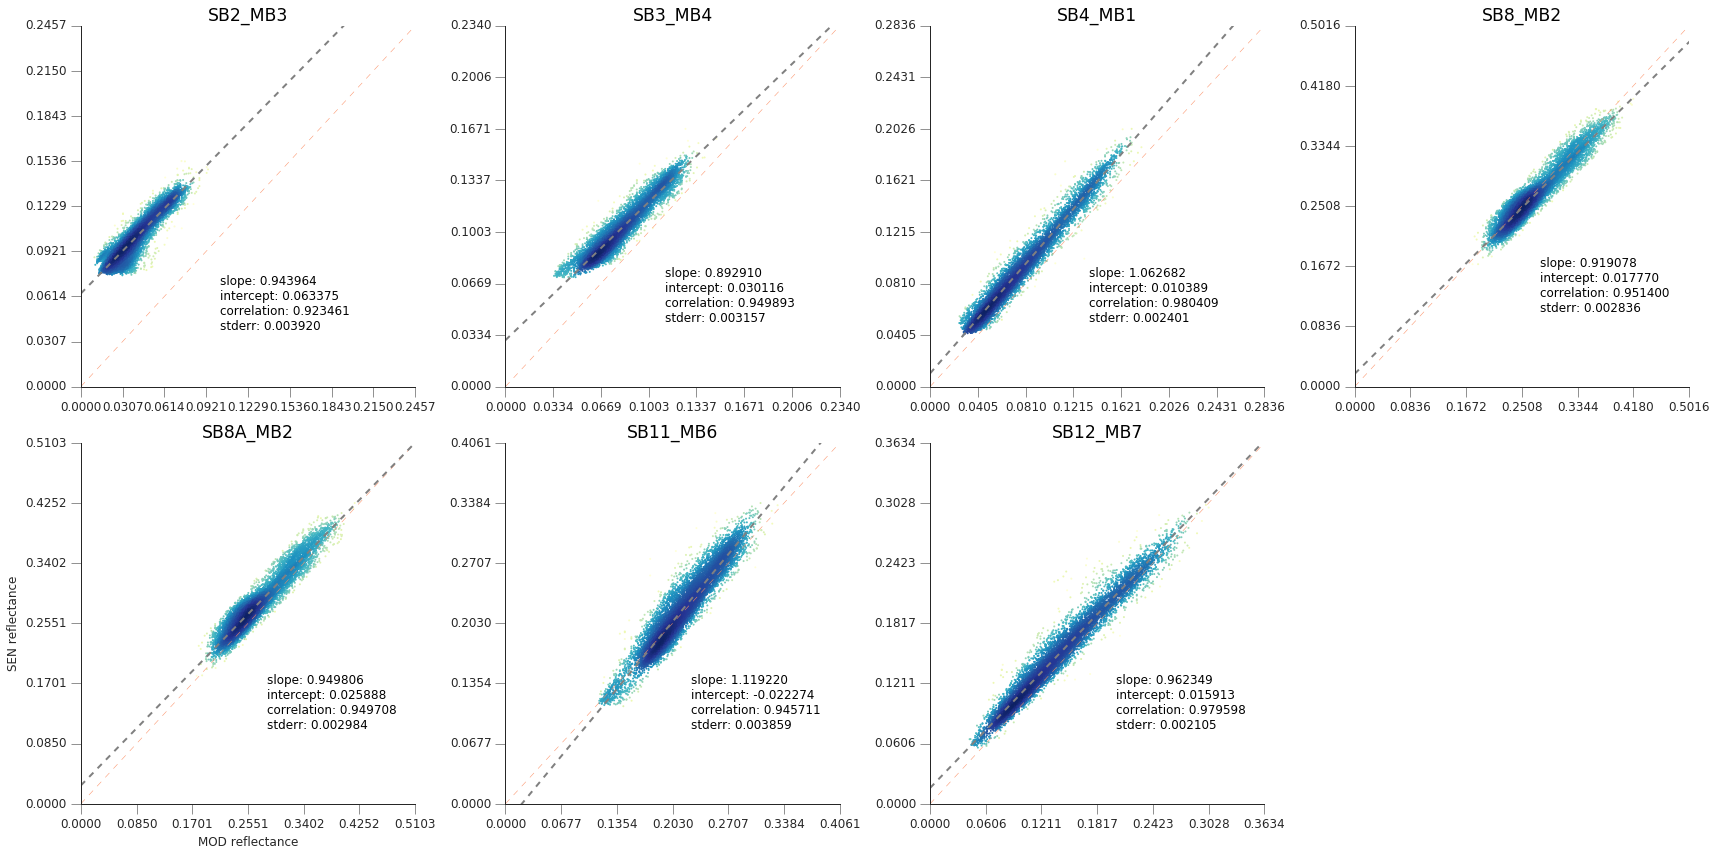

In [109]:
plot_config()
fig = plt.figure()
gs = gridspec.GridSpec(2,4)  # generate a grid space
fig = plt.figure(figsize=(24,12))
names = ('SB2_MB3,SB3_MB4,SB4_MB1,SB8_MB2,SB8A_MB2,SB11_MB6,SB12_MB7').split(',')
cmap = cm.get_cmap('YlGnBu')
psfsolve = []
for i in range(7):
    ax = fig.add_subplot(gs[i])
    data = np.array(to_regs[4+i])
    
    
    mod = data[0]
    sen = data[1]
    
    dis = mod-sen
    std = np.std(dis)
    mean = np.mean(dis)
    inl = (dis > mean-3*std)&(dis < mean+3*std)
    s = mod[inl]
    m = sen[inl]

    mval = np.nanmax([s,m])
    fit = np.polyfit(m,s,1)
    fit_fn = np.poly1d(fit)
    xy = np.vstack([m,s])
    z = gaussian_kde(xy)(xy)
    ax.scatter(m,s, c=z, s=4, edgecolor='',norm=colors.LogNorm(vmin=z.min(), vmax=z.max()*1.2), cmap = cmap)
    ax.plot([0,1],[0.,1], '--',linewidth=0.5)
    ax.plot(np.arange(0,1,0.1), fit_fn(np.arange(0,1,0.1)), '--', color='grey')
    slope,inter, rval, pval, std = r = scipy.stats.linregress(m,s)
    ax.set_title('%s'%names[i])
    ax.text(mval*(4./6.),mval*(1.5/6.),'slope: %02f \nintercept: %02f \ncorrelation: %02f \nstderr: %02f'%(slope,inter, rval, std), 
        )
    pretty_axes(ax)
    ax.set_xlim(0,mval)
    ax.set_ylim(0,mval)
    ax.set_yticks(np.arange(0,mval+0.1,mval/5.))
    ax.set_xticks(np.arange(0,mval+0.1,mval/5.))
    if i==4:
        ax.set_xlabel ( "MOD reflectance")
        ax.set_ylabel ( "SEN reflectance")
    psfsolve.append([slope,inter])
plt.tight_layout()

In [341]:
parallel_rw_pkl(to_regs, 'to_regs', 'w')

Length of data: 11
Length of data: 11


In [146]:
psfsolve = np.array(psfsolve)
psfsolve

array([[ 0.94396372,  0.06337542],
       [ 0.89290999,  0.03011558],
       [ 1.06268167,  0.01038946],
       [ 0.91907771,  0.01776961],
       [ 0.94980581,  0.0258882 ],
       [ 1.11922009, -0.02227448],
       [ 0.96234873,  0.0159126 ]])

In [118]:
paras = [[1.0643882094331185, 0.0078185737045573522],
 [1.0282218810406503, -0.0016855022247735801],
 [1.0417708949680591, -0.0027975993725735393],
 [0.9862465310589299, -0.0030209919897268289],
 [1.0035860701533228, 0.0011174662363786503],
 [1.0061923768577434, -0.0065058015219046084],
 [0.92872302458511657, 0.011373313797587048]]

In [115]:
psfs

array([[  24.03670488,  329.28109422,    8.21156216,  -21.92877746,
          49.92825343,  103.24736351],
       [  25.84989531,  319.13408271,    9.02137912,  -17.30119499,
          54.28744309,  117.72072308],
       [  20.34380686,  310.05258802,    7.68929054,  -20.20594463,
          51.24613469,  125.79665481],
       [  25.65831059,  331.77434   ,    8.26914652,  -18.98274506,
          58.96302278,   93.93448873],
       [  27.08271778,  331.96593023,    8.41321639,  -18.8125706 ,
          57.90903304,   92.61856343],
       [  36.12786679,  240.59093701,    7.04018294,  -23.48520651,
          58.81159708,  103.02285762],
       [  28.58401928,  265.45895558,    7.2976923 ,  -19.74625101,
          64.55664791,  115.26868696]])

In [138]:
def atmom(p, TOA_s, BRDF_m, para, simp=True): 
    alpha, beta, path_r = p
    if simp:
        beta=0
    else:
        pass
    a,b, = para
    
    mod = BRDF_m
    sen = TOA_s
    
    dis = mod-sen
    std = np.std(dis)
    mean = np.mean(dis)
    inl = (dis > mean-3*std)&(dis < mean+3*std)
    m = mod[inl]
    s = sen[inl]
    
    semi_sen = a*np.array(m) + b
    cost = np.sum(abs(np.array(s) - path_r - (alpha*semi_sen/(1-beta*semi_sen))))
    return cost

def opt(i):
    psolve = optimize.fmin_l_bfgs_b(atmom,x0,approx_grad=True, iprint=-1,bounds=bounds, args=(to_regs[i+4][0], to_regs[i+4][1], np.array(paras)[i],True))
    return psolve

In [139]:
bounds = [0.,1], [0.,1], [0.,1]
x0 = np.array([1,0,1])
pool = multiprocessing.Pool(processes = 7)
retval = pool.map(opt, range(7))
pool.close()
pool.join()

In [144]:
atmsolve = np.array([i[0] for i in retval])

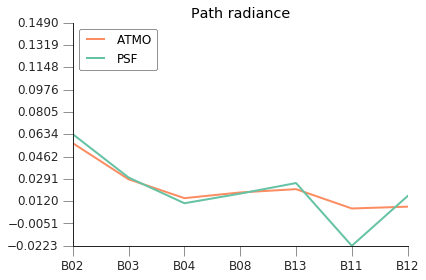

In [272]:
fig = plt.figure()
ax = fig.add_subplot(111)
maxval = np.max([atmsolve.T[2],psfsolve.T[1]])
minval = np.min([atmsolve.T[2],psfsolve.T[1]])
ax.plot(atmsolve.T[2], label='ATMO')
ax.plot(psfsolve.T[1],label='PSF')
ax.set_title('Path radiance')
pretty_axes(ax)
ax.set_ylim(minval,maxval)
ax.set_yticks(np.arange(minval,maxval+0.1,(maxval-minval)/5.))
ax.set_xticklabels(['B02', 'B03', 'B04', 'B08', 'B13', 'B11', 'B12'])
ax.legend(loc=2)

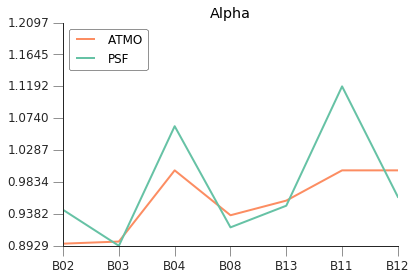

In [295]:
fig = plt.figure()
ax = fig.add_subplot(111)
maxval = np.max([atmsolve.T[0],psfsolve.T[0]])
minval = np.min([atmsolve.T[0],psfsolve.T[0]])
ax.plot(atmsolve.T[0], label='ATMO')
ax.plot(psfsolve.T[0],label='PSF')
ax.set_title('Alpha')
pretty_axes(ax)
ax.set_ylim(minval,maxval)
ax.set_yticks(np.arange(minval,maxval+0.1,(maxval-minval)/5.))
ax.set_xticklabels(['B02', 'B03', 'B04', 'B08', 'B13', 'B11', 'B12'])
ax.legend(loc=2)

In [151]:
ls *Xingtai*

160101_161231_SONET_Xingtai.dubovik


In [158]:
df = pd.read_csv('160101_161231_SONET_Xingtai.dubovik', skiprows=3, na_values=["N/A"])

In [160]:
pas = ['Date(dd-mm-yyyy)',
 'Time(hh:mm:ss)',
 'Julian_Day',
 'AOT_1640',
 'AOT_1020',
 'AOT_870',
 'AOT_675',
 'AOT_667',
 'AOT_555',
 'AOT_551',
 'AOT_532',
 'AOT_531',
 'AOT_500',
 'AOT_490',
 'AOT_443',
 'AOT_440',
 'AOT_412',
 'AOT_380',
 'AOT_340',
 'Water(cm)']

In [175]:
date = df[pas][6:13]
date

,Date(dd-mm-yyyy),Time(hh:mm:ss),Julian_Day,AOT_1640,AOT_1020,AOT_870,AOT_675,AOT_667,AOT_555,AOT_551,AOT_532,AOT_531,AOT_500,AOT_490,AOT_443,AOT_440,AOT_412,AOT_380,AOT_340,Water(cm)
6,03:05:2016,01:22:19,124.057164,0.031955,0.041477,0.047839,0.060413,NaN,NaN,NaN,NaN,NaN,0.060192,NaN,NaN,0.069243,NaN,0.075497,0.070629,0.447453
7,03:05:2016,07:22:17,124.307141,0.081640,0.090919,0.101287,0.118541,NaN,NaN,NaN,NaN,NaN,0.135848,NaN,NaN,0.152733,NaN,0.174680,0.192274,0.760989
8,03:05:2016,08:37:27,124.359340,0.091557,0.102394,0.111964,0.129180,NaN,NaN,NaN,NaN,NaN,0.155331,NaN,NaN,0.176462,NaN,0.202620,0.220729,0.824685
9,03:05:2016,09:32:01,124.397234,0.097034,0.110542,0.120147,0.141056,NaN,NaN,NaN,NaN,NaN,0.180543,NaN,NaN,0.208450,NaN,0.244123,0.268813,0.877700
10,03:05:2016,10:06:10,124.420949,0.102942,0.117834,0.126913,0.147866,NaN,NaN,NaN,NaN,NaN,0.190915,NaN,NaN,0.219997,NaN,0.256489,0.279838,0.903077
11,03:05:2016,22:46:36,124.949028,0.110888,0.134589,0.139996,0.154928,NaN,NaN,NaN,NaN,NaN,0.181862,NaN,NaN,0.201206,NaN,0.222006,0.231482,1.120504
12,03:05:2016,23:13:34,124.967755,0.116685,0.139560,0.145124,0.159921,NaN,NaN,NaN,NaN,NaN,0.183771,NaN,NaN,0.201428,NaN,0.221696,0.231096,1.147006


In [297]:
aeso = np.array(date.AOT_1640),np.array(date.AOT_1020),np.array(date.AOT_870),np.array(date.AOT_675),np.array(date.AOT_500),np.array(date.AOT_440),np.array(date.AOT_380),np.array(date.AOT_340)

In [187]:
wv = [1640, 1020,870, 675, 500, 440, 380, 340]

In [195]:
aeso = np.array(aeso).T

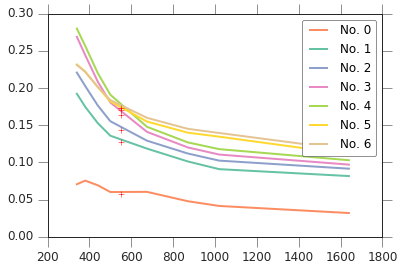

In [209]:
aot550 = []
for i,j in enumerate(aeso):
    plt.plot(wv, j, label = 'No. %s'%i)
    f = interpolate.interp1d(wv,j, kind='cubic')
    xnew = 550
    ynew = f(xnew)
    aot550.append(ynew)
    plt.plot(550, ynew, 'r+')
plt.legend()

In [211]:
aot550[-3]

array(0.1734720605027159)

In [212]:
gp = parallel_rw_pkl(None, '6S_emulation', 'r')

In [218]:
mete = readxml(fhead+'metadata.xml')
sz = mete['mSz']
sa = mete['mSa']

In [219]:
atmos = readmeteo(path+'auxiliary/ECMWFT')
ozone = np.mean(atmos['TCO3']*46.728972)
ozone
water = np.mean(atmos['TCWV']/10.)
water

0.51058646543526354

In [288]:
ozone

0.3713181711032324

In [216]:
refs = 0.2,0.35, 0.3,0.4, 0.41,0.5, 0.51 

In [263]:
regs = []
for ii in range(7):
    if ii==0:
        ref = np.random.choice(Sent.ravel(), 1000)
        to_cor = []
        for i,j in enumerate(ref):
            to_cor.append([sz,sa, 0.903077, ozone, aot550[-3].tolist(), j])

        cored = gp[ii][0].predict(np.array(to_cor))
        s,m = np.array(to_cor)[:,-1], cored[0]
        regs.append([s,m])
    else:
        Sent = gdal_read(bands[ii], path)[keys[ii]]
        ref = np.random.choice(Sent.ravel(), 1000)
        to_cor = []
        for i,j in enumerate(ref):
            to_cor.append([sz,sa, water, ozone, aot550[-3].tolist(), j])
        
        cored = gp[ii][0].predict(np.array(to_cor))
        s,m = np.array(to_cor)[:,-1], cored[0]
        regs.append([s,m])

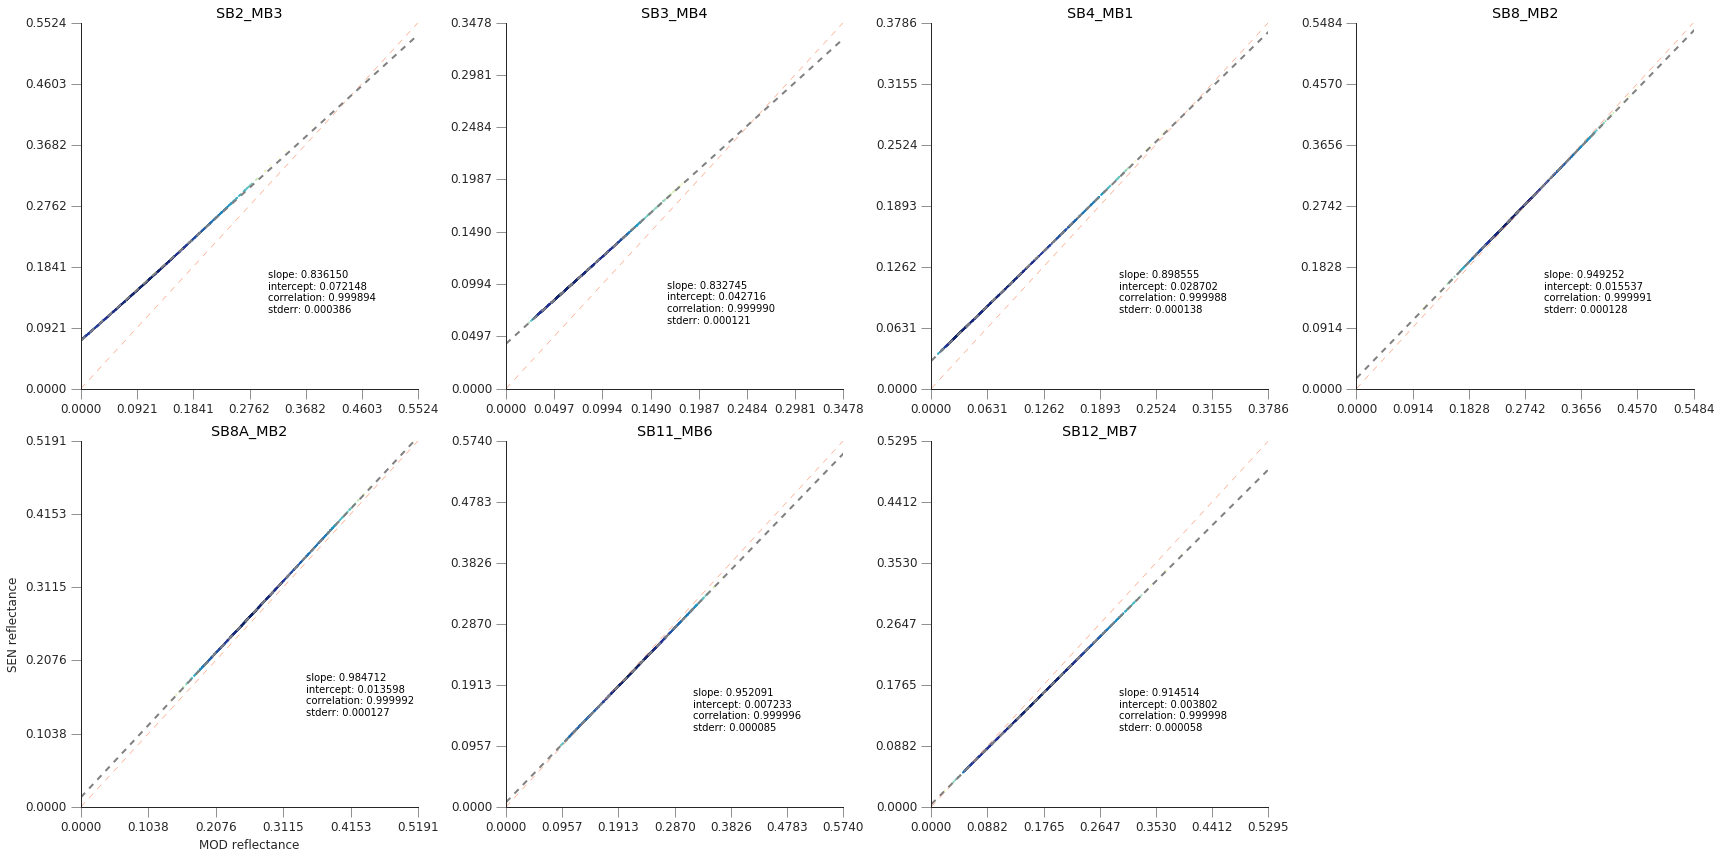

In [264]:
fig = plt.figure
gs = gridspec.GridSpec(2,4)  # generate a grid space
fig = plt.figure(figsize=(24,12))
names = ('SB2_MB3,SB3_MB4,SB4_MB1,SB8_MB2,SB8A_MB2,SB11_MB6,SB12_MB7').split(',')
cmap = cm.get_cmap('YlGnBu')
solve_6s = []
for i in range(7):
    ax = fig.add_subplot(gs[i])
    data = np.array(regs[i])
    mval = np.nanmax(data)
    
    mod = data[0].astype(float)
    sen = data[1].astype(float)
    
    dis = mod-sen
    std = np.std(dis)
    mean = np.mean(dis)
    inl = (dis > mean-3*std)&(dis < mean+3*std)
    s = mod[inl]
    m = sen[inl]

    
    fit = np.polyfit(m,s,1)
    fit_fn = np.poly1d(fit)
    xy = np.vstack([m,s])
    z = gaussian_kde(xy)(xy)
    ax.scatter(m,s, c=z, s=4, edgecolor='',norm=colors.LogNorm(vmin=z.min(), vmax=z.max()*1.2), cmap = cmap)
    ax.plot([0,1],[0.,1], '--',linewidth=0.5)
    ax.plot(np.arange(0,1,0.1), fit_fn(np.arange(0,1,0.1)), '--', color='grey')
    slope,inter, rval, pval, std = r = scipy.stats.linregress(m,s)
    ax.set_title('%s'%names[i])
    ax.text(mval*(4./6.),mval*(1.5/6.),'slope: %02f \nintercept: %02f \ncorrelation: %02f \nstderr: %02f'%(slope,inter, rval, std), 
        )
    pretty_axes(ax)
    ax.set_xlim(0,mval)
    ax.set_ylim(0,mval)
    ax.set_yticks(np.arange(0,mval+0.1,mval/5.))
    ax.set_xticks(np.arange(0,mval+0.1,mval/5.))
    if i==4:
        ax.set_xlabel ( "MOD reflectance")
        ax.set_ylabel ( "SEN reflectance")
    solve_6s.append([slope,inter])
plt.tight_layout()

In [294]:
atmsolve

array([[ 0.8959399 ,  0.        ,  0.05647779],
       [ 0.89892351,  0.        ,  0.02876397],
       [ 1.        ,  0.        ,  0.01429803],
       [ 0.93626743,  0.        ,  0.01866714],
       [ 0.95704675,  0.        ,  0.02120602],
       [ 1.        ,  0.        ,  0.00636866],
       [ 1.        ,  0.        ,  0.00777009]])

In [262]:
psfsolve

array([[ 0.94396372,  0.06337542],
       [ 0.89290999,  0.03011558],
       [ 1.06268167,  0.01038946],
       [ 0.91907771,  0.01776961],
       [ 0.94980581,  0.0258882 ],
       [ 1.11922009, -0.02227448],
       [ 0.96234873,  0.0159126 ]])

In [267]:
solve_6s = np.array(solve_6s)
solve_6s

array([[ 0.83614977,  0.07214754],
       [ 0.83274494,  0.04271574],
       [ 0.89855511,  0.02870191],
       [ 0.94925231,  0.01553734],
       [ 0.98471237,  0.01359827],
       [ 0.95209138,  0.00723308],
       [ 0.91451382,  0.00380214]])

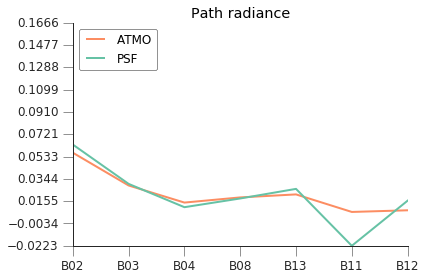

In [284]:
fig = plt.figure()
ax = fig.add_subplot(111)
maxval = np.max([atmsolve.T[2],psfsolve.T[1], solve_6s.T[1]])
minval = np.min([atmsolve.T[2],psfsolve.T[1], solve_6s.T[1]])
ax.plot(atmsolve.T[2], label='ATMO')
ax.plot(psfsolve.T[1],label='PSF')
#ax.plot(solve_6s.T[1],label='6S')
ax.set_title('Path radiance')
pretty_axes(ax)
ax.set_ylim(minval,maxval)
ax.set_yticks(np.arange(minval,maxval+0.1,(maxval-minval)/5.))
ax.set_xticklabels(['B02', 'B03', 'B04', 'B08', 'B13', 'B11', 'B12'])
ax.legend(loc=2)

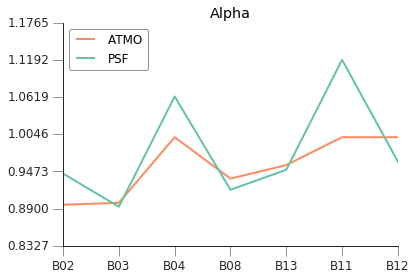

In [283]:
fig = plt.figure()
ax = fig.add_subplot(111)
maxval = np.max([atmsolve.T[0],psfsolve.T[0], solve_6s.T[0]])
minval = np.min([atmsolve.T[0],psfsolve.T[0], solve_6s.T[0]])
ax.plot(atmsolve.T[0], label='ATMO')
ax.plot(psfsolve.T[0],label='PSF')
#ax.plot(solve_6s.T[0],label='6S')
ax.set_title('Alpha')
pretty_axes(ax)
ax.set_ylim(minval,maxval)
ax.set_yticks(np.arange(minval,maxval+0.1,(maxval-minval)/5.))
ax.set_xticklabels(['B02', 'B03', 'B04', 'B08', 'B13', 'B11', 'B12'])
ax.legend(loc=2)

In [290]:
def cost6s(p,to_regs =None):
    print p
    toa = to_regs[0]
    bot = to_regs[1]
    m = (toa<1)&(bot<1)
    to_cor = []
    for i,j in enumerate(toa[m]):
        to_cor.append([sz,sa, p[0], p[1], p[2].tolist(), j])
    cored = gp[ii][0].predict(np.array(to_cor))
    cos = np.nansum(abs(cored[0]-bot[m]))
    print cos
    return cos

In [299]:
to_regs[0]

(array([ 0.09691664,  0.09435243,  0.09369792, ...,  0.10498802,
         0.10613403,  0.10781667]),
 masked_array(data = [0.018000000000000002 -- 0.031598932548164115 ..., 0.045244105242549994
  0.04707805119944564 0.04547087366978499],
              mask = [False  True False ..., False False False],
        fill_value = 1e+20))

In [308]:
x.shape,np.array(y).shape

((10065,), (10065,))

Estimated coefficients (true, normal, RANSAC):
(array(82.1903908407869), array([[  7.24400030e-07]]), array([[ 0.9323848]]))


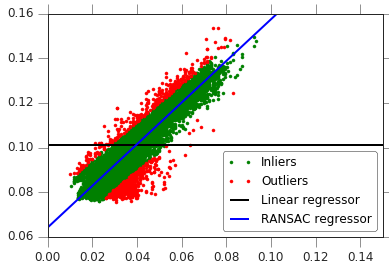

In [340]:
import numpy as np
from matplotlib import pyplot as plt

from sklearn import linear_model


m = np.random.choice(range(10065), 1000)

y, x = to_regs[0][0].reshape((10065,1)), np.array(to_regs[0][1]).reshape((10065,1))
# Fit line using all data
model = linear_model.LinearRegression()
model.fit(x, y)

# Robustly fit linear model with RANSAC algorithm
model_ransac = linear_model.RANSACRegressor(linear_model.LinearRegression())
model_ransac.fit(x, y)
inlier_mask = model_ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)

# Predict data of estimated models
line_x = np.arange(0, 1, 0.01)
line_y = model.predict(line_x[:, np.newaxis])
line_y_ransac = model_ransac.predict(line_x[:, np.newaxis])

# Compare estimated coefficients
print("Estimated coefficients (true, normal, RANSAC):")
print(coef, model.coef_, model_ransac.estimator_.coef_)

plt.plot(x[inlier_mask], y[inlier_mask], '.g', label='Inliers')
plt.plot(x[outlier_mask], y[outlier_mask], '.r', label='Outliers')
plt.plot(line_x, line_y, '-k', label='Linear regressor')
plt.plot(line_x, line_y_ransac, '-b', label='RANSAC regressor')
plt.xlim(0,0.15)
plt.ylim(0.06, 0.16)
plt.legend(loc='best')

In [332]:
linregress(x[inlier_mask].ravel(), y[inlier_mask].ravel())

LinregressResult(slope=0.98086979756358295, intercept=0.062660211423710643, rvalue=0.96027443570401294, pvalue=0.0, stderr=0.0030017770691787562)